# CS 135 day03: Linear Regression 

An investigation into the Formulas used for model training aka fitting

# Objectives

* Learn how to apply the standard "least squares" formulas for 'training' linear regression in 1 dimension
* Learn how to apply the standard "least squares" formulas for 'training' linear regression in many dimensions (with matrix math)
* Learn how these formulas minimize *mean squared error*, but maybe not other error metrics


# Outline

* [Part 1: Linear Regression with Linear Algebra](#Part-1:-Linear-Regression-with-Linear-Algebra)
* [Part 2: What is a matrix inverse?](#Part-2:-What-is-the-inverse-of-a-matrix?)
* [Part 3: When can we trust numerical computation of the inverse?](#Part-3:-Is-the-numerical-inverse-reliable?)
* [Part 4: Returning to Linear Regression using numerically stable formulas](#Part-4:-Returning-to-general-case-linear-regression)



# Takeaways

* Exact formulas exist for estimating the weight coefficients $w$ and bias/intercept $b$ for linear regression
* * Requires matrix multiplication and other operations, solving a linear system with $F+1$ unknowns ($F$ weights and 1 bias)
* Prefer `np.linalg.solve` over `np.linalg.inv`.
* * Numerical methods for computing inverses (like `np.linalg.inv`) are unreliable if the matrix $A$ is almost singular.
* Linear algebra is a very important field of mathematics for understanding when a solution to a linear system of equations exists
* These formulas minimize *mean squared error*, but likely may not minimize other error metrics
* * Many ML methods are motivated by what is *mathematically convenient*.
* * In practice, you should *definitely* consider if another objective is better for your regression task

# Import libraries

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import sklearn.metrics

In [ ]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set('notebook', style='whitegrid', font_scale=0.8)
plt.rcParams["figure.figsize"] = (4, 3)

### Generate a simple 1D regression dataset

* Use true slope of 2.345
* Use true intercept of 0.0
* Add a small amount of noise to each y value, so that the problem isn't "too easy"

In [ ]:
true_slope = 2.345

N = 7
x_N = np.linspace(-1, 1, N);
ypure_N = true_slope * x_N

prng = np.random.RandomState(987)
y_N = ypure_N + 0.7 * prng.randn(N) # add Gaussian noise with stddev 0.7

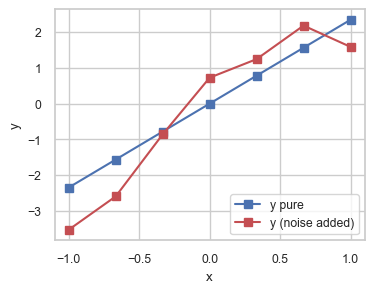

In [ ]:
plt.plot(x_N, ypure_N, 'bs-', label='y pure')
plt.plot(x_N, y_N, 'rs-', label='y (noise added)');
plt.legend(loc='lower right');
plt.xlabel('x'); plt.ylabel('y');

<a id="part1"></a>

# Part 0: Linear Regression with 1 predictor

In this section, all code is already written. Just read through it and make sure you understand.

## Prediction step

Here, the prediction step for any specific scalar input $x$ is

$$
\hat{y}(x) = w \cdot x + b
$$

In [ ]:
def predict_1d(x_N, w, b):
    ''' Prediction step of F=1 linear regression with bias
    
    Returns
    -------
    yhat_N : 1D array, shape (N,)
        Predicted y value for each entry in x_N
    '''
    N = np.asarray(x_N).shape
    yhat_N = w * x_N + b # Elementwise multiply, then add
    return yhat_N

## Training Step

To minimize MSE on training set, first compute the mean $x$ and the mean $y$:

$$
\bar{y} = \text{mean}( y_1, \ldots y_N)
$$

$$
\bar{x} = \text{mean}( x_1, \ldots x_N)
$$


Then, via formulas found in textbook, the best estimates of the slope and intercept (that minimize MSE) are given by:

$$
w^* = \frac{ \sum_{n=1}^N (x_n - \bar{x}) (y_n - \bar{y}) }{\sum_{n=1}^N (x_n - \bar{x})^2 }
$$

$$
b^* = \bar{y} - w^* \bar{x} \quad \quad \quad \quad
$$

### Using the noise-free y value which actually do fall along a line

Sanity check : we should recover the true-slope, with zero intercept

In [ ]:
xbar = np.mean(x_N)
ybar = np.mean(ypure_N)
w_est = np.inner(x_N - xbar, ypure_N - ybar) / np.inner(x_N - xbar, x_N - xbar)
print(w_est)

b_est = ybar - w_est * xbar
print(b_est)

2.3449999999999998
-1.7938032012157886e-16


### Using the noisy y value

In [ ]:
xbar = np.mean(x_N)
ybar = np.mean(y_N)

w_est = np.inner(x_N - xbar, y_N - ybar) / np.inner(x_N - xbar, x_N - xbar)
b_est = ybar - w_est * xbar

print("Estimated slope: " + str(w_est))
print("Estimated bias: " + str(b_est))

Estimated slope: 2.8916527199994326
Estimated bias: -0.17718525644944352


<a id="part3"></a>

# Part 1: Linear Regression with Linear Algebra

Now we will do the same thing but with linear algebra. Because we still have only 1 predictor, we don't *have* to do linear algebra, and we could just apply the hand-derived equations. But we can apply the more general linear algebra approach to this setting and check that we get the same result.

Given a dataset of $N$ examples and $F$ feature dimensions, where

* $\tilde{\mathbf{X}}$ is an $N \times F +1$ matrix of feature vectors, where we'll assume the last column is all ones
* $\mathbf{y}$ is an $N \times 1$ column vector of outputs

Goal:
* estimate the vector $w \in \mathbb{R}^F$ of weight coefficients
* estimate the bias scalar $b$ (aka intercept)

Let's set $G = F +1$.

Then, we can alternatively write our parameters as a compact vector of size $G$

\begin{align}
\theta &= [\theta_1, \theta_2, \ldots \theta_{F}, \theta_{G}]
\\
    &= [ w_1, w_2, \ldots w_F, b]
\end{align}

To get started, lets first *form* the array $\tilde{X}$

In [ ]:
x_N1 = x_N[:,np.newaxis]
x_N1.shape

(7, 1)

In [ ]:
xtilde_N2 = np.hstack([x_N1, np.ones((x_N.size, 1))])
print(xtilde_N2)

[[-1.          1.        ]
 [-0.66666667  1.        ]
 [-0.33333333  1.        ]
 [ 0.          1.        ]
 [ 0.33333333  1.        ]
 [ 0.66666667  1.        ]
 [ 1.          1.        ]]


## Code exercise: Prediction step

In [ ]:
def predict(xtilde_NG, theta_G):
    ''' Prediction step of general linear regression
    
    G = number of features plus 1 (for intercept)
    
    Returns
    -------
    yhat_N : 1D array, shape (N,)
        Predicted y value for each entry in x_N
    '''
    N = np.asarray(x_N).shape
    yhat_N = np.matmul(xtilde_NG, theta_G) # Matrix multiply 
    return yhat_N

## Training step


Remember that the optimal vector $\theta^*$ satisfies

$$
\left( \tilde{\mathbf{X}}^T \tilde{\mathbf{X}} \right) \theta^* = \tilde{\mathbf{X}}^T \mathbf{y}
$$

We can "solve" for theta by writing (**this critically assumes the inverse exists**)

$$
\theta^* = (\tilde{\mathbf{X}}^T \tilde{\mathbf{X}} )^{-1} \tilde{\mathbf{X}}^T \mathbf{y}
\\
~\\
w^* = [\theta^*_1 ~ \theta^*_2 \ldots \theta^*_F ]^T
\\
~\\
b^* = \theta^*_{F+1}
$$

We need to compute a *matrix inverse* to do this (well, we don't actually *have to*, because there's only 1 feature. We could use the alternatively-derived solution in Part 0, but we won't).

Let's try this out. First, print out the $\tilde{X}$ array

In [ ]:
xtilde_N2

array([[-1.        ,  1.        ],
       [-0.66666667,  1.        ],
       [-0.33333333,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.33333333,  1.        ],
       [ 0.66666667,  1.        ],
       [ 1.        ,  1.        ]])

Next, lets compute the matrix product $\tilde{X}^T \tilde{X}$, which is a $2 \times 2$ matrix

In [ ]:
xTx_22 = np.matmul(xtilde_N2.T, xtilde_N2)
print(xTx_22)

[[ 3.11111111e+00 -2.22044605e-16]
 [-2.22044605e-16  7.00000000e+00]]


Next, lets compute the INVERSE of $\tilde{X}^T \tilde{X}$, which is again a $2 \times 2$ matrix

In [ ]:
inv_xTx_22 = np.linalg.inv(xTx_22) # compute the inverse!
print(inv_xTx_22)

[[3.21428571e-01 1.01959257e-17]
 [1.01959257e-17 1.42857143e-01]]


Next, let's compute the optimal $\theta$ vector according to our formula above

In [ ]:
theta_G = np.matmul(inv_xTx_22, np.matmul(xtilde_N2.T, y_N[:,np.newaxis])) # compute theta vector
print(theta_G)

[[ 2.89165272]
 [-0.17718526]]


In [ ]:
print("Estimated slope: " + str(theta_G[0]))
print("Estimated bias: " + str(theta_G[1]))

Estimated slope: [2.89165272]
Estimated bias: [-0.17718526]


We should get the SAME results as in Part 0, from noisy data. 

So this formula for the general case looks super easy, right?

Not so fast...

Let's take a minute and review just what the heck an *inverse* is, before we just blindly implement this formula...

<a id="part4"></a>

# Part 2: What is the inverse of a matrix?

Let $A$ be a square matrix with shape $(D, D)$.

We say that matrix $A^{-1}$ is the *inverse* of $A$ if the product of $A$ and $A^{-1}$ yields the $D \times D$ *identity* matrix:

$$
A A^{-1} = I
$$

If $A^{-1}$ exists, it will also be a $D\times D $ square matrix.

In Python, we can compute the inverse of a matrix using `np.linalg.inv`

In [ ]:
# Define a square matrix with shape(3,3)
A = np.diag(np.asarray([1., -2., 3.]))
print(A)

[[ 1.  0.  0.]
 [ 0. -2.  0.]
 [ 0.  0.  3.]]


In [ ]:
# Compute its inverse
invA = np.linalg.inv(A)
print(invA)

[[ 1.          0.          0.        ]
 [-0.         -0.5        -0.        ]
 [ 0.          0.          0.33333333]]


In [ ]:
np.matmul(A, invA) # should equal identity

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

Remember, in 1 dimensions, the inverse of $a$ is just $1/a$, since $a \cdot \frac{1}{a} = 1.0$

In [ ]:
A = np.asarray([[2]])
print(A)

[[2]]


In [ ]:
invA = np.linalg.inv(A)
print(invA)

[[0.5]]


## Does the inverse always exist?

No! Remember:

* Even when $D=1$, if $A=0$, then the inverse does not exist ($\frac{1}{A}$ is undefined)
* When $D \geq 2$, there are *infinitely many* square matrices $A$ that do not have an inverse



In [ ]:
# Example 1:
A = np.asarray([[0, 0], [0, 1.337]])
print(A)
try:
    np.linalg.inv(A)
except Exception as e:
    print(str(type(e)) + ": " + str(e))

[[0.    0.   ]
 [0.    1.337]]
<class 'numpy.linalg.LinAlgError'>: Singular matrix


In [ ]:
# Example 2:
A = np.asarray([[3.4, 3.4], [3.4, 3.4]])
print(A)
try:
    np.linalg.inv(A)
except Exception as e:
    print(str(type(e)) + ": " + str(e))

[[3.4 3.4]
 [3.4 3.4]]
<class 'numpy.linalg.LinAlgError'>: Singular matrix


In [ ]:
# Example 3:
A = np.asarray([[-1.2, 4.7], [-2.4, 9.4]])
print(A)
try:
    np.linalg.inv(A)
except Exception as e:
    print(str(type(e)) + ": " + str(e))

[[-1.2  4.7]
 [-2.4  9.4]]
<class 'numpy.linalg.LinAlgError'>: Singular matrix


What do these examples have in common???

The columns of $A$ are not linearly independent!

In other words, $A$ is not invertible whenever we can exactly construct one column of $A$ by a linear combination of other columns

$$
A_{:,D} = c_1 A_{:,1} + c_2 A_{:,2} + \ldots c_{D-1} A_{:,D-1}
$$

where $c_1$, $c_2$, $\ldots c_{D-1}$ are scalar weights.

In [ ]:
# Look, here's the first column:
A[:, 0]

array([-1.2, -2.4])

In [ ]:
# And here's it being perfectly reconstructed by a scalar times the second column
A[:, 1] * -1.2/4.7

array([-1.2, -2.4])

In [ ]:
# Example 3:
A = np.asarray([[1.0, 2.0, -3.0], [2, 4, -6.0], [1.0, 1.0, 1.0]])
print(A)
try:
    np.linalg.inv(A)
except Exception as e:
    print(str(type(e)) + ": " + str(e))

[[ 1.  2. -3.]
 [ 2.  4. -6.]
 [ 1.  1.  1.]]
<class 'numpy.linalg.LinAlgError'>: Singular matrix


### Important result from linear algebra: Invertible Matrix Theorem


Given a specific matrix $A$, the following statements are either *all* true or *all* false:

* $A$ has an inverse (e.g. a matrix $A^{-1}$ exists s.t. $A A^{-1} = I$)
* All $D$ columns of $A$ are linearly independent
* The columns of $A$ span the space $\mathbb{R}^D$
* $A$ has a non-zero determinant

For more implications, see the *Invertible Matrix Theorem*:

<https://en.wikipedia.org/wiki/Invertible_matrix#Properties>

<a id="part5"></a>

# Part 3: Is the numerical inverse reliable?

Can we always trust the results of `np.linalg.inv`?

Not really. Taking inverses is very tricky if the input matrix is not *very* well conditioned.

### A "good" example, where inverse works

In [ ]:
# 3 indep rows of size 3.
prng = np.random.RandomState(8675309)

x_NF = prng.randn(3, 3)
xTx_FF = np.matmul(x_NF.T, x_NF)

In [ ]:
np.linalg.inv(np.matmul(x_NF.T, x_NF))

array([[ 6.89049845, -2.94940875,  0.53906734],
       [-2.94940875,  1.95347099,  0.39420508],
       [ 0.53906734,  0.39420508,  1.12274369]])

In [ ]:
# First, verify the `inv` function computes *something* of the right shape

inv_xTx_FF = np.linalg.inv(xTx_FF)
print(inv_xTx_FF)

[[ 6.89049845 -2.94940875  0.53906734]
 [-2.94940875  1.95347099  0.39420508]
 [ 0.53906734  0.39420508  1.12274369]]


In [ ]:
# Next, verify the `inv` function result is ACTUALLY the inverse

ans_FF = np.matmul(xTx_FF, inv_xTx_FF)

print(ans_FF)
print("\nis this close enough to identity matrix? " + str(
    np.allclose(ans_FF, np.eye(3))))

[[ 1.00000000e+00  3.78543709e-16 -1.02908588e-16]
 [ 1.00637374e-16  1.00000000e+00 -8.15941066e-17]
 [ 2.83970606e-16 -4.39010674e-16  1.00000000e+00]]

is this close enough to identity matrix? True


### A *bad* example, where `np.linalg.inv` may be unreliable

In [ ]:
# Only 2 indep rows of size 3. should NOT be invertible                      
# verify: determinant is close to zero                              
x_NF = prng.randn(2, 3)  
xTx_FF = np.matmul(x_NF.T, x_NF)

In [ ]:
xTx_FF

array([[ 0.72724601, -0.34643484, -0.61400395],
       [-0.34643484,  0.80016893, -1.19669946],
       [-0.61400395, -1.19669946,  4.01004776]])

In [ ]:
# First, verify the `inv` function computes *something* of the right shape

inv_xTx_FF = np.linalg.inv(xTx_FF)
print(inv_xTx_FF)

[[2.46265272e+15 2.94415957e+15 1.25568396e+15]
 [2.94415957e+15 3.51981240e+15 1.50119988e+15]
 [1.25568396e+15 1.50119988e+15 6.40261699e+14]]


In [ ]:
# Next, verify the `inv` function result is ACTUALLY the inverse

ans_FF = np.matmul(xTx_FF, inv_xTx_FF)

print(ans_FF)
print("\nis this close enough to identity matrix? " + str(
    np.allclose(ans_FF, np.eye(3))))

[[ 0.96261955  0.176167   -0.20301762]
 [ 0.06237689  0.34972495  0.106876  ]
 [-0.11882483  0.33249602  0.99899684]]

is this close enough to identity matrix? False


### What just happened?

We just asked for an inverse.

NumPy gave us a result that WAS NOT AN INVERSE, but we received NO WARNINGS OR ERRORS!

So what should we do? Avoid naively calling `np.linalg.inv` and trusting the result. 

A better thing to do is use `np.linalg.solve`, as this will be more *stable* (trustworthy).

<https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html>

What `np.linalg.solve(A, b)` does is that it uses DIFFERENT algorithm to directly return an answer to the question

What vector $\theta$ would be a valid solution to the equation

$$
A \theta = b
$$

for some matrix $A$ and vector $b$

So for our case, we are requesting a solution (a specific vector $\theta$) to the equation

$$
\tilde{X}^T \tilde{X} \theta = \tilde{X}^T y
$$

<a id="part6"></a>

# Part 4: Returning to general case linear regression

Construct a simple case with $N=2$ examples and $F=2$ features.

For general linear regression, this is an UNDER-determined system (we have 3 unknowns, but only 2 examples).



In [ ]:
true_w_F1 = np.asarray([1.0, 1.0])[:,np.newaxis]
true_b = np.asarray([0.0])

In [ ]:
x_NF = np.asarray([[1.0, 2.0], [1.0, 1.0]]) + prng.randn(2,2) * 0.001
print(x_NF)

[[0.99912666 2.00015601]
 [0.9996129  0.99976079]]


In [ ]:
y_N1 = np.matmul(x_NF, true_w_F1) + true_b
print(y_N1)

[[2.99928267]
 [1.99937369]]


### Quick visual of what this dataset looks like. N=2, F=2.

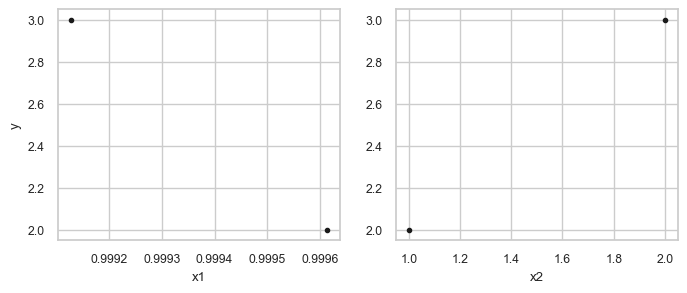

In [ ]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(8,3));
axgrid[0].plot(x_NF[:,0], y_N1, 'k.');
axgrid[1].plot(x_NF[:,1], y_N1, 'k.');
axgrid[0].set_ylabel('y')
axgrid[0].set_xlabel('x1')
axgrid[1].set_xlabel('x2');

Now, let's look at what happens when we try to predict on this dataset

In [ ]:
theta1_G = np.asarray([7.24938235, 1.00303752, -6.25]);
theta2_G = np.asarray([true_w_F1[0,0], true_w_F1[1,0], true_b[0]])
xtilde_NG = np.hstack([x_NF, np.ones((2, 1))])

print('True y')
print(y_N1[:,0])
print('Predictions with theta1: ' + str(theta1_G))
print(predict(xtilde_NG, theta1_G)) # Assumes you have solved Exercise 3a
print("Predictions with theta2: " + str(theta2_G))
print(predict(xtilde_NG, theta2_G))

True y
[2.99928267 1.99937369]
Predictions with theta1: [ 7.24938235  1.00303752 -6.25      ]
[0. 0.]
Predictions with theta2: [1. 1. 0.]
[0. 0.]


### Expected output of the above (if you've solved the coding exercise in Part 1)

<pre>
True y
[2.99928267 1.99937369]
Predictions with theta1: [ 7.24938235  1.00303752 -6.25      ]
[2.99928267 1.99937369]
Predictions with theta2: [1. 1. 0.]
[2.99928267 1.99937369]
</pre>

Punchline: $N=F$, yet the model has $G = F+1$ free parameters. 

So, while not all parameters do well, there do exist INFINITELY many weights $w$ and bias values $b$ that can reconstruct our $y$ **perfectly**

Question: Can various estimation strategies find such weights?

### Try out sklearn


In [ ]:
import sklearn.linear_model

In [ ]:
lr = sklearn.linear_model.LinearRegression()

In [ ]:
lr.fit(x_NF, y_N1)

LinearRegression()

Print the estimated weights $w$ and intercept $b$

In [ ]:
print(lr.coef_)
print(lr.intercept_)

[[-4.85815419e-04  9.99513712e-01]]
[1.0005847]


Print the predicted values for $y$, alongside the *true* ones

In [ ]:
print("Results for sklearn")
print("Predicted y: " + str(np.squeeze(lr.predict(x_NF))))
print("True y:      " + str(np.squeeze(y_N1)))

Results for sklearn
Predicted y: [2.99928267 1.99937369]
True y:      [2.99928267 1.99937369]


### Prep for our formulas: make the $\tilde{\mathbf{X}}$ array

Will have shape $N \times (F+1)$

Let's define $G = F+1$

In [ ]:
xtilde_NG = np.hstack([x_NF, np.ones((2, 1))])
print(xtilde_NG)

[[0.99912666 2.00015601 1.        ]
 [0.9996129  0.99976079 1.        ]]


In [ ]:
xTx_GG = np.matmul(xtilde_NG.T, xtilde_NG)

### Try out using our least-squares formula, as implemented with `np.linalg.inv`

In [ ]:
inv_xTx_GG = np.linalg.inv(xTx_GG)
theta_G1 = np.matmul(inv_xTx_GG, np.matmul(xtilde_NG.T, y_N1))

Best estimate of the weights and bias (after "unpacking" the vector $\theta$):

In [ ]:
w_F = theta_G1[:-1, 0]
b = theta_G1[-1]
print(w_F)
print(b)

[8.         1.00195312]
[-4.]


In [ ]:
yhat_N1 = np.matmul(xtilde_NG, theta_G1)

In [ ]:
print("Results for using naive np.linalg.inv")
print("Predicted y: " + str(yhat_N1[:,0]))
print("True y:      " + str(y_N1[:,0]))

Results for using naive np.linalg.inv
Predicted y: [5.99707581 4.99861664]
True y:      [2.99928267 1.99937369]


Expected result: you should see that predictions might be *quite far* from true y values!

### Try out using our formulas, as implemented with `np.linalg.solve`

What should happen: We can find estimated parameters $w, b$ that perfectly predict the $y$

In [ ]:
theta_G1 = np.linalg.solve(xTx_GG, np.matmul(xtilde_NG.T, y_N1))

In [ ]:
w_F = theta_G1[:-1,0]
b = theta_G1[-1,0]
print(w_F)
print(b)

[7.24938235 1.00303752]
-6.25


In [ ]:
yhat_N1 = np.matmul(xtilde_NG, theta_G1)

In [ ]:
print("Results for using more stable formula implementation with np.linalg.solve")
print("Predicted y: " + str(yhat_N1[:,0]))
print("True y:      " + str(y_N1[:,0]))

Results for using more stable formula implementation with np.linalg.solve
Predicted y: [2.99928267 1.99937369]
True y:      [2.99928267 1.99937369]
